# 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. 데이터 로드

In [2]:
df = pd.read_excel('../화재 위험도 계산 데이터/최종본.xlsx')
df.head()

,year,month,day,ws,ta,hm,rn,result
0,2019,1,1,3.0,4.1,36,0.0,0
1,2019,1,2,3.9,4.2,30,0.0,1
2,2019,1,3,5.1,5.3,20,0.0,1
3,2019,1,4,5.8,6.3,20,0.0,0
4,2019,1,5,4.4,7.0,40,0.0,1


In [3]:
result_counts = df['result'].value_counts(normalize=True) * 100  # 비율(%)
print("result 0과 1의 비율:")
print(result_counts)

result 0과 1의 비율:
result
0    72.109589
1    27.890411
Name: proportion, dtype: float64


# 2. 데이터 분석

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

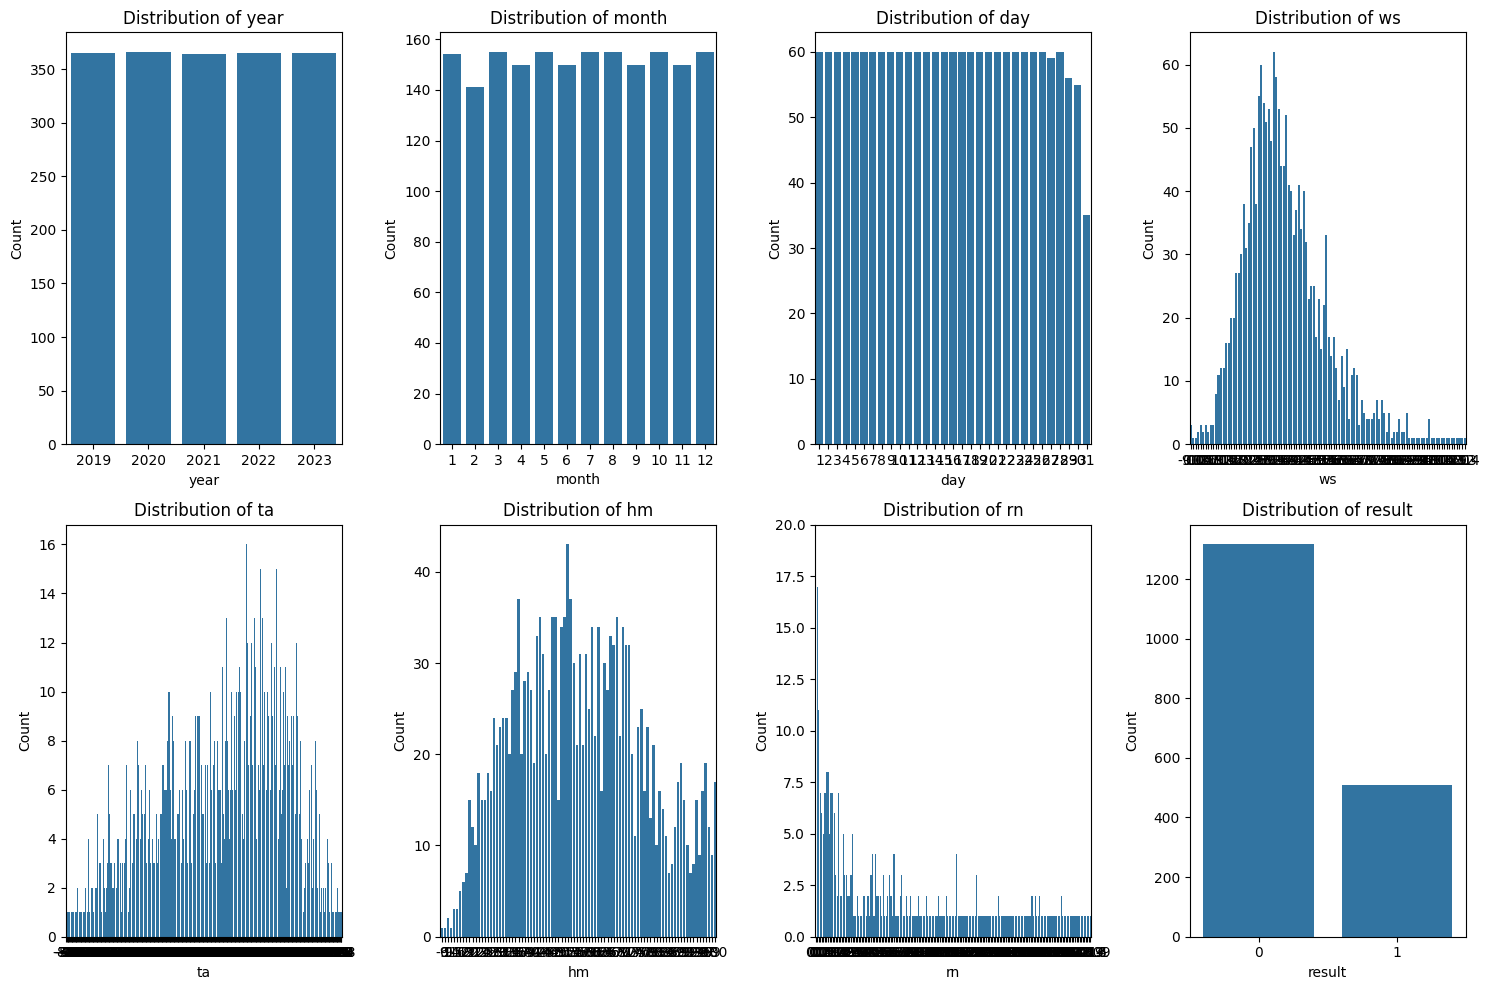

In [5]:
# 변수 리스트
columns_to_plot = ['year', 'month', 'day', 'ws', 'ta', 'hm', 'rn', 'result']
# 바플롯 시각화
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # rn의 y축 범위 조정
    if column == 'rn':
        plt.ylim(0, 20)  # y축 범위를 0에서 5로 설정

plt.tight_layout()
plt.show()

# 3. 데이터 전처리

In [4]:
# X, y 분리
X = df[['year', 'month', 'day', 'ws', 'ta', 'hm', 'rn']]  # 특징
y = df['result']  # 레이블

In [5]:
# 훈련 세트와 테스트 세트로 9:1 비율로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['ws', 'ta', 'hm', 'rn']),  # 연속형 변수 표준화
        ('cat', OneHotEncoder(), ['year', 'month', 'day'])     # 원-핫 인코딩
    ]
)

In [8]:
import xgboost as xgb

In [10]:
# 모델 파이프라인
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', xgb.XGBClassifier(n_estimators=100, random_state=42))])

# 4. 모델학습

In [11]:
# 모델 학습
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ws', 'ta', 'hm', 'rn']),
                                                 ('cat', OneHotEncoder(),
                                                  ['year', 'month', 'day'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_cate...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# 5. 예측 및 평가

In [12]:
y_val_pred = model.predict(X_test)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.6885245901639344
검증 세트 ROC AUC 점수: 0.5641711229946524
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80       132
           1       0.39      0.22      0.28        51

    accuracy                           0.69       183
   macro avg       0.57      0.54      0.54       183
weighted avg       0.64      0.69      0.66       183



In [25]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률

# 7. 테스트 세트와 예측 결과 출력
test_results = pd.DataFrame({
    '정답': y_test,
    '예측': y_test_pred,
    '예측 확률': y_test_pred_proba,
    # '날짜': pd.to_datetime(X_test[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d'),
    '풍속 (ws)': X_test['ws'].values,
    '기온 (ta)': X_test['ta'].values,
    '습도 (hm)': X_test['hm'].values,
    '일일강수량 (rn)': X_test['rn'].values
})

In [14]:
print("\n테스트 세트 결과:")
test_results.sample(15)


테스트 세트 결과:


,정답,예측,예측 확률,풍속 (ws),기온 (ta),습도 (hm),일일강수량 (rn)
1761,1,1,0.54,1.1,19.6,42,0.0
524,1,1,0.56,1.9,25.1,53,0.0
575,1,1,0.57,0.6,25.5,93,51.3
1069,0,0,0.47,2.0,16.3,64,0.1
334,0,0,0.22,0.6,11.2,90,2.5
684,0,0,0.23,4.2,19.5,46,0.0
674,0,0,0.27,2.6,16.8,36,0.0
965,0,0,0.26,12.0,25.9,96,35.8
252,0,0,0.18,5.2,27.8,83,0.0
93,1,0,0.33,2.9,17.6,16,0.0


In [26]:
# 특성 중요도 가져오기
importances = model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'